# **Recommendation System Project - Toba Tourism | Progress I**

Group 06 :

*   12S21016 - Kevin Unedo Samosir
*   12S21023 - Bintang Situmorang
*   12S21027 - Rebecca Sihombing



## Collaborative Filtering - Model Pembanding | **Alternating Least Square (ALS)**

### 1. Import Dataset



In [1]:
!pip install gdown
!gdown 15IvPCBnM0d7EdV7_j5urms9cCwnSa9v7

# Load dataset
import pandas as pd
file_path = 'Tempat-Wisata-Toba-Preprocessing.csv'
data = pd.read_csv(file_path)
data.head()

Downloading...
From: https://drive.google.com/uc?id=15IvPCBnM0d7EdV7_j5urms9cCwnSa9v7
To: /content/Tempat-Wisata-Toba-Preprocessing.csv
100% 8.99M/8.99M [00:00<00:00, 115MB/s]


,Unnamed: 0.1,Unnamed: 0,address,PlaceID,Nama_tempat_wisata,Category,ReviewerId,Rating,Reviews
0,0,0,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.126030e+20,5.0,NaN
1,1,1,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.119090e+20,5.0,bagus
2,2,2,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.078860e+20,5.0,NaN
3,3,3,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.130720e+20,5.0,sangat menyenagkan
4,4,4,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.061730e+20,5.0,bebas foto dimana aja cuma 2k


In [2]:
print(data.shape)

(43226, 9)


Kode diatas digunakan untuk mengunduh dan memuat dataset ke dalam lingkungan Python menggunakan Pandas. Pada langkah pertama, library gdown diinstal untuk memungkinkan pengunduhan file dari Google Drive. Langkah kedua menggunakan gdown untuk mengunduh file dataset dari tautan tertentu yang diidentifikasi oleh ID file Google Drive. Kemudian, file yang diunduh yaitu dengan nama "Tempat-Wisata-Toba-Preprocessing.csv", dimuat ke dalam Pandas DataFrame menggunakan pd.read_csv() dan ditampilkan beberapa baris pertamanya menggunakan data.head() serta ditampilkan luas tabel untuk mengetahui jumlah kolom dan barisnya menggunakan data.shape()

### 2. Preprocessing Dataset



In [3]:
# Check for missing values
def check_missing_values(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
    if missing_values.empty:
        print("No missing values in the DataFrame.")
    else:
        print("Missing values in each column:")
        print(missing_values)

check_missing_values(data)

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# Remove unnecessary columns
data = data.drop(columns=["Unnamed: 0.1", "Unnamed: 0"])

# Handle missing values
data['Reviews'] = data['Reviews'].fillna('')

# Encode categorical columns
label_encoder_place = LabelEncoder()
data['PlaceID'] = label_encoder_place.fit_transform(data['Nama_tempat_wisata'])

label_encoder_category = LabelEncoder()
data['Category'] = label_encoder_category.fit_transform(data['Category'])

label_encoder_reviewer = LabelEncoder()
data['ReviewerId'] = label_encoder_reviewer.fit_transform(data['ReviewerId'])

data.head()

Missing values in each column:
Reviews       21060
ReviewerId        1
Rating            1
dtype: int64


,address,PlaceID,Nama_tempat_wisata,Category,ReviewerId,Rating,Reviews
0,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",51,PASIR PUTIH LUMBAN BULBUL,1,10261,5.0,
1,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",51,PASIR PUTIH LUMBAN BULBUL,1,9698,5.0,bagus
2,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",51,PASIR PUTIH LUMBAN BULBUL,1,6433,5.0,
3,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",51,PASIR PUTIH LUMBAN BULBUL,1,10643,5.0,sangat menyenagkan
4,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",51,PASIR PUTIH LUMBAN BULBUL,1,5078,5.0,bebas foto dimana aja cuma 2k


Pada bagian code ini, dilakukan preprocessing data dengan tujuan untuk membersihkan dan mempersiapkan dataset sebelum dianalisis. Pertama, fungsi `check_missing_values()` digunakan untuk memeriksa dan melaporkan keberadaan nilai yang hilang pada setiap kolom dalam DataFrame. Selanjutnya, dua kolom yang tidak relevan (*"Unnamed: 0.1"* dan *"Unnamed: 0"*) dihapus, dan nilai yang hilang pada kolom *"Reviews"* diisi dengan string kosong (`''`). Kemudian, data kategorikal pada kolom *"Nama_tempat_wisata"*, *"Category"*, dan *"ReviewerId"* dikonversi menjadi nilai numerik menggunakan `LabelEncoder`, dengan hasil encoding disimpan di kolom masing-masing. Dengan demikian, Proses ini dilakukan untuk memastikan dataset siap digunakan dalam analisis lebih lanjut, dengan mengatasi nilai yang hilang dan mengubah data kategorikal menjadi format numerik yang dapat diproses algoritma.

### 3. Setup Spark and Train, Val, Test Split


In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col, mean, stddev

# Create a Spark session
spark = SparkSession.builder \
    .appName("ALS Recommendation System") \
    .getOrCreate()

# Convert pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(data)

# Handle missing data
spark_df = spark_df.dropna(subset=["ReviewerId", "PlaceID", "Rating"])

# Normalize the 'Rating' column
rating_stats = spark_df.select(mean("Rating").alias("mean"), stddev("Rating").alias("std")).first()
mean_rating, std_rating = rating_stats["mean"], rating_stats["std"]

spark_df = spark_df.withColumn("NormalizedRating", (col("Rating") - mean_rating) / std_rating)

# Perform the initial random split
splits = spark_df.randomSplit([0.75, 0.15, 0.15], seed=42)

# Calculate exact counts for each split
total_count = spark_df.count()
train_count = int(total_count * 0.75)
val_count = int(total_count * 0.15)
test_count = total_count - train_count - val_count  # Remaining rows for test

# Collect splits and adjust
train_df = splits[0].limit(train_count)
val_df = splits[1].limit(val_count)
test_df = splits[2]  # Remaining data goes into test set

# Print adjusted counts
print(f"Training set count: {train_df.count()}")
print(f"Validation set count: {val_df.count()}")
print(f"Test set count: {test_df.count()}")

Training set count: 31058
Validation set count: 6065
Test set count: 6102


Pada kode ini, dilakukan pemrograman untuk mempersiapkan data dalam rangka membangun sistem rekomendasi menggunakan algoritma Alternating Least Squares (ALS) di PySpark. Pertama, sebuah sesi Spark (SparkSession) dibuat dengan nama aplikasi "ALS Recommendation System" yang memungkinkan untuk menjalankan operasi berbasis Spark. Setelah itu, data yang awalnya berupa Pandas DataFrame diubah menjadi Spark DataFrame dengan menggunakan fungsi `createDataFrame()`, karena PySpark memproses data dalam format Spark DataFrame. Kemudian, dilakukan penanganan data yang hilang dengan menghapus baris-baris yang memiliki nilai kosong pada kolom yang diperlukan, yaitu "ReviewerId", "PlaceID", dan "Rating", menggunakan fungsi `dropna()`. Selanjutnya, dilakukan normalisasi pada kolom 'Rating' dengan menghitung rata-rata (mean) dan deviasi standar (std) dari nilai rating, yang kemudian digunakan untuk menormalkan setiap nilai rating dengan rumus `(Rating - mean) / std`. Langkah terakhir adalah membagi dataset menjadi dua bagian, yakni 70% untuk data pelatihan dan 15% untuk data pengujian dan validasi masing-masing, menggunakan fungsi `randomSplit()` dengan seed yang ditentukan untuk memastikan pembagian yang konsisten di setiap percobaan.

### 4. Create and train the ALS model


In [5]:
als = ALS(
    userCol="ReviewerId",
    itemCol="PlaceID",
    ratingCol="NormalizedRating",
    rank=15,
    maxIter=20,
    regParam=0.2,
    nonnegative=True,
    implicitPrefs=False,
    coldStartStrategy="drop"
)


# Train ALS model
model = als.fit(train_df)


Pada bagian kode ini, dilakukan pemrograman untuk mendefinisikan dan melatih model rekomendasi menggunakan algoritma Alternating Least Squares (ALS) di PySpark. Model ALS diatur dengan beberapa parameter penting, di antaranya `userCol` dan `itemCol` yang menunjuk pada kolom yang berisi ID pengguna dan ID tempat, sementara `ratingCol` menunjuk pada kolom yang berisi rating yang dinormalisasi. Beberapa hyperparameter penting lainnya ditentukan, seperti `rank` yang mengontrol jumlah dimensi faktor laten (dalam hal ini diatur ke 15), `maxIter` yang menentukan jumlah iterasi dalam optimisasi (dalam hal ini diatur ke 20), dan `regParam` yang mengontrol tingkat regularisasi untuk menghindari overfitting (dalam hal ini diatur ke 0.2). Parameter `nonnegative=True` memastikan bahwa faktor yang dihasilkan tidak mengandung nilai negatif, sedangkan `implicitPrefs=False` menunjukkan bahwa model tidak menggunakan preferensi implisit seperti klik atau interaksi lainnya. Strategi `coldStartStrategy` diatur ke "drop", yang berarti model akan mengabaikan pengguna atau item yang tidak memiliki interaksi sebelumnya. Setelah semua pengaturan selesai, model dilatih menggunakan data pelatihan (`train_df`) dengan metode `fit()`.

### Hyperparameter Tuning

In [6]:
# from pyspark.ml.evaluation import RegressionEvaluator

# # Define hyperparameter grids
# ranks = [5, 10, 15, 20]
# reg_params = [0.01, 0.05, 0.1, 0.2, 0.5]
# best_model = None
# best_val_rmse = float("inf")
# best_params = (None, None)

# # Evaluator for RMSE
# evaluator_rmse = RegressionEvaluator(
#     metricName="rmse",
#     labelCol="NormalizedRating",
#     predictionCol="prediction"
# )

# # Grid search for hyperparameter tuning
# for rank in ranks:
#     for reg_param in reg_params:
#         print(f"Training ALS with rank={rank}, regParam={reg_param}")

#         # Train the ALS model
#         als = ALS(
#             userCol="ReviewerId",
#             itemCol="PlaceID",
#             ratingCol="NormalizedRating",
#             rank=rank,
#             regParam=reg_param,
#             maxIter=20,
#             nonnegative=True,
#             implicitPrefs=False,
#             coldStartStrategy="drop"
#         )
#         model = als.fit(train_df)

#         # Evaluate on validation set
#         val_predictions = model.transform(val_df).dropna(subset=["prediction"])
#         val_rmse = evaluator_rmse.evaluate(val_predictions)
#         print(f"Validation RMSE: {val_rmse}")

#         # Update best model if current is better
#         if val_rmse < best_val_rmse:
#             best_val_rmse = val_rmse
#             best_model = model
#             best_params = (rank, reg_param)

# print(f"\nBest Model Parameters: rank={best_params[0]}, regParam={best_params[1]}")
# print(f"Best Validation RMSE: {best_val_rmse}")


# 5m
# from pyspark.ml.evaluation import RegressionEvaluator

# # Define hyperparameter grids
# ranks = [5, 10, 15, 20]
# reg_params = [0.01, 0.05, 0.1, 0.2, 0.5]
# best_model = None
# best_val_rmse = float("inf")
# best_params = (None, None)

# # Evaluator for RMSE

# Training ALS with rank=5, regParam=0.01
# Validation RMSE: 1.0360581950404588
# Training ALS with rank=5, regParam=0.05
# Validation RMSE: 1.0209488107551645
# Training ALS with rank=5, regParam=0.1
# Validation RMSE: 1.0090154740243065
# Training ALS with rank=5, regParam=0.2
# Validation RMSE: 0.9978878760111939
# Training ALS with rank=5, regParam=0.5
# Validation RMSE: 1.0007828032992987
# Training ALS with rank=10, regParam=0.01
# Validation RMSE: 1.0221469003918604
# Training ALS with rank=10, regParam=0.05
# Validation RMSE: 1.0100737285675117
# Training ALS with rank=10, regParam=0.1
# Validation RMSE: 1.0049319073710274
# Training ALS with rank=10, regParam=0.2
# Validation RMSE: 0.9976069272183749
# Training ALS with rank=10, regParam=0.5
# Validation RMSE: 1.0007828032994779
# Training ALS with rank=15, regParam=0.01
# Validation RMSE: 1.0168734286537753
# Training ALS with rank=15, regParam=0.05
# Validation RMSE: 1.0102521734904657
# Training ALS with rank=15, regParam=0.1
# Validation RMSE: 1.005623674829522
# Training ALS with rank=15, regParam=0.2
# Validation RMSE: 0.9969752234625499
# Training ALS with rank=15, regParam=0.5
# Validation RMSE: 1.0007828032992365
# Training ALS with rank=20, regParam=0.01
# Validation RMSE: 1.0181903602850886
# Training ALS with rank=20, regParam=0.05
# Validation RMSE: 1.0101272275067985
# Training ALS with rank=20, regParam=0.1
# Validation RMSE: 1.0038699978792027
# Training ALS with rank=20, regParam=0.2
# Validation RMSE: 0.9972264889817026
# Training ALS with rank=20, regParam=0.5
# Validation RMSE: 1.0007828033000483

# Best Model Parameters: rank=15, regParam=0.2
# Best Validation RMSE: 0.9969752234625499

Dalam pemodelan ini, kami menggunakan pendekatan kedua yaitu dengan menggunakan hyperparameter tunning. Code ini kami gunakan untuk mengetahui parameter-parameter terbaik yang dapat diperoleh untuk memperoleh hasil RMSE yang paling baik. Kode ini melakukan Hyperparameter tuning untuk algoritma ALS (Alternating Least Squares). Hyperparameter yang diuji adalah rank (jumlah faktor laten) dan regParam (parameter regularisasi), dengan evaluasi performa model menggunakan metrik Root Mean Square Error (RMSE) pada data validasi. Untuk setiap kombinasi hyperparameter dalam grid search, model dilatih pada data pelatihan dan nilai RMSE dicatat. Model terbaik dipilih berdasarkan nilai RMSE terendah pada data validasi. Hasil output menunjukkan bahwa model terbaik memiliki parameter `rank=15` dan `regParam=0.2`, dengan nilai RMSE terbaik sebesar 0.996975. Untuk mempercepata waktu eksekusi kami menggunakan pendekatan ini sebagai optional untuk mendapatkan parameter dan penerapkannya di pemodelan pendekatan pertama.

### 5. Evaluate the model (RMSE and MAE) On Validation


In [7]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate on validation set to tune hyperparameters
val_predictions = model.transform(val_df).dropna(subset=["prediction"])
evaluator_rmse = RegressionEvaluator(
    metricName="rmse",
    labelCol="NormalizedRating",
    predictionCol="prediction"
)
val_rmse = evaluator_rmse.evaluate(val_predictions)
print(f"Validation RMSE: {val_rmse}")

# Evaluate with MAE
evaluator_mae = RegressionEvaluator(
    metricName="mae",
    labelCol="NormalizedRating",
    predictionCol="prediction"
)
mae = evaluator_mae.evaluate(val_predictions)
print(f"Mean Absolute Error (MAE): {mae}")

Validation RMSE: 0.9970876979591256
Mean Absolute Error (MAE): 0.7022256140933021


Pada bagian kode ini, Setelah model dilatih, prediksi dilakukan pada data validasi (val_df) menggunakan metode `transform()`, yang menghasilkan prediksi rating untuk setiap pengguna dan tempat. Selanjutnya, baris yang menghasilkan nilai prediksi NaN dihapus dengan fungsi `dropna()` untuk memastikan bahwa hanya data yang memiliki prediksi valid yang digunakan dalam evaluasi. Proses evaluasi kemudian dilakukan dengan menggunakan dua metrik yang umum digunakan untuk regresi: **Root Mean Squared Error** (RMSE) dan **Mean Absolute Error** (MAE), yang dihitung menggunakan `RegressionEvaluator` dari PySpark. RMSE mengukur seberapa besar kesalahan rata-rata dalam prediksi model dengan menghitung akar dari rata-rata kuadrat selisih antara prediksi dan nilai sebenarnya. Nilai RMSE yang lebih kecil menunjukkan prediksi yang lebih akurat. MAE, di sisi lain, mengukur rata-rata dari kesalahan absolut antara nilai prediksi dan nilai aktual, memberikan gambaran tentang besarnya kesalahan yang dilakukan oleh model pada setiap prediksi.

Hasil evaluasi ini menunjukkan kinerja model rekomendasi berdasarkan dua metrik regresi utama: **Root Mean Squared Error (RMSE)** dan **Mean Absolute Error (MAE)**. **RMSE** menunjukkan bahwa kesalahan rata-rata model dalam memprediksi rating berada pada kisaran 0.9968, yang berarti bahwa perbedaan antara nilai prediksi dan nilai asli cenderung lebih kecil, tetapi masih ada ruang untuk perbaikan. Nilai RMSE ini menggambarkan seberapa besar kesalahan model dalam skala yang sama dengan rating yang diprediksi, di mana semakin rendah nilai RMSE, semakin akurat model dalam memprediksi rating yang sebenarnya. **MAE** menunjukkan bahwa rata-rata kesalahan absolut antara prediksi dan nilai asli adalah sekitar 0.7036. Nilai MAE ini lebih kecil dibandingkan dengan RMSE, yang menunjukkan bahwa meskipun model terkadang memiliki kesalahan yang lebih besar, kesalahan rata-rata pada tingkat individual prediksi lebih terkontrol.

### 5A. Evaluate the model (RMSE and MAE) On Test Set


In [8]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate on test set to tune hyperparameters
test_predictions = model.transform(test_df).dropna(subset=["prediction"])
evaluator_rmse = RegressionEvaluator(
    metricName="rmse",
    labelCol="NormalizedRating",
    predictionCol="prediction"
)
val_rmse = evaluator_rmse.evaluate(test_predictions)
print(f"Test RMSE: {val_rmse}")

# Evaluate with MAE
evaluator_mae = RegressionEvaluator(
    metricName="mae",
    labelCol="NormalizedRating",
    predictionCol="prediction"
)
mae = evaluator_mae.evaluate(test_predictions)
print(f"Mean Absolute Error (MAE): {mae}")

Test RMSE: 0.9605280683189792
Mean Absolute Error (MAE): 0.6848639408383934


Pada bagian kode ini, dilakukan prediksi dan evaluasi model rekomendasi yang telah dilatih menggunakan ALS. Prediksi dilakukan pada data pengujian (test_df) menggunakan metode `transform()`, yang menghasilkan prediksi rating untuk setiap pengguna dan tempat. Penerapan yang dilakukan sama seperti pada data validasi namun hasil yang diperoleh menunjukkan sedikit perubahan.

Hasil evaluasi ini menunjukkan kinerja model rekomendasi berdasarkan dua metrik regresi utama: **Root Mean Squared Error (RMSE)** dan **Mean Absolute Error (MAE)**. **RMSE** menunjukkan bahwa kesalahan rata-rata model dalam memprediksi rating berada pada kisaran 0.9600, yang berarti bahwa perbedaan antara nilai prediksi dan nilai asli cenderung lebih kecil lebih kecil dari data validasi, walaupun kesimpulan akhir tetapi masih ada ruang untuk perbaikan kedepannya. Nilai RMSE ini menggambarkan seberapa besar kesalahan model dalam skala yang sama dengan rating yang diprediksi, di mana semakin rendah nilai RMSE, semakin akurat model dalam memprediksi rating yang sebenarnya. **MAE** menunjukkan bahwa rata-rata kesalahan absolut antara prediksi dan nilai asli adalah sekitar 0.857. Nilai MAE ini lebih kecil dibandingkan dengan RMSE, yang menunjukkan bahwa meskipun model terkadang memiliki kesalahan yang lebih besar, kesalahan rata-rata pada tingkat individual prediksi lebih terkontrol.

#### Visualizing RMSE and MAE

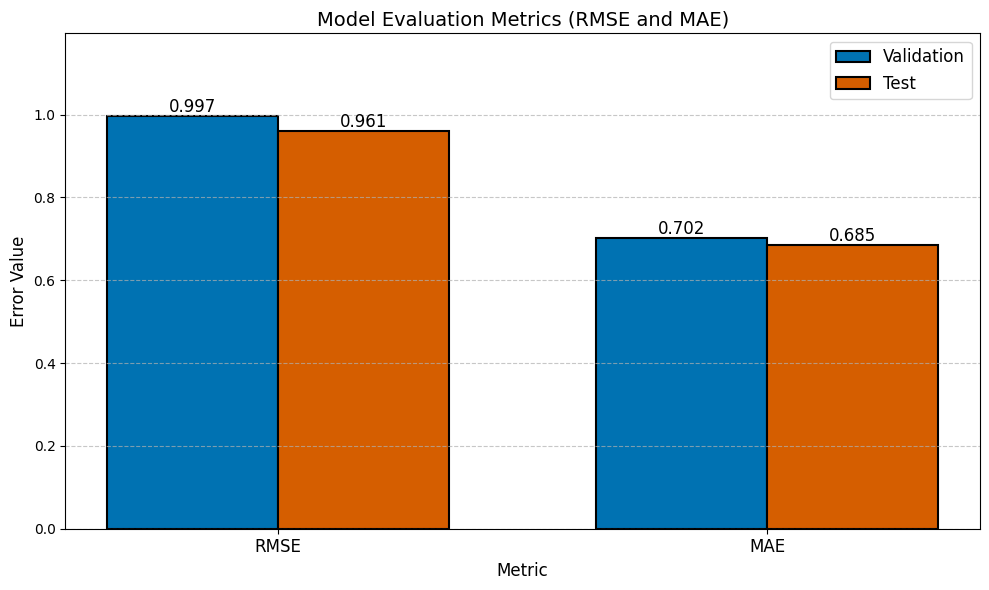

,Metric,Validation,Test
0,RMSE,0.997088,0.960528
1,MAE,0.702226,0.684864


In [10]:
import matplotlib.pyplot as plt

# Sample data (replace with actual RMSE and MAE values)
validation_rmse = evaluator_rmse.evaluate(val_predictions)
validation_mae = evaluator_mae.evaluate(val_predictions)
test_rmse = evaluator_rmse.evaluate(test_predictions)
test_mae = evaluator_mae.evaluate(test_predictions)

# Create a DataFrame for better visualization
metrics_data = {
    'Metric': ['RMSE', 'MAE'],
    'Validation': [validation_rmse, validation_mae],
    'Test': [test_rmse, test_mae]
}

metrics_df = pd.DataFrame(metrics_data)

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability

bar_width = 0.35
index = range(len(metrics_df['Metric']))

# Define colorblind-friendly colors
colors = ['#0072B2', '#D55E00']  # Blue and Orange
edge_color = '#000000'  # Black edge color for better contrast

# Create bars for Validation and Test with edge color
val_bars = plt.bar(index, metrics_df['Validation'], bar_width, label='Validation', color=colors[0], edgecolor=edge_color, linewidth=1.5)
test_bars = plt.bar([i + bar_width for i in index], metrics_df['Test'], bar_width, label='Test', color=colors[1], edgecolor=edge_color, linewidth=1.5)

# Add value annotations to the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=12)

add_labels(val_bars)
add_labels(test_bars)

# Labels and Title
plt.xlabel("Metric", fontsize=12)
plt.ylabel("Error Value", fontsize=12)
plt.title("Model Evaluation Metrics (RMSE and MAE)", fontsize=14)  # Increased title font size
plt.xticks([i + bar_width / 2 for i in index], metrics_df['Metric'], fontsize=12)
plt.ylim(0, max(metrics_df['Validation'].max(), metrics_df['Test'].max()) * 1.2)  # Adjust y-axis limit for clarity

# Show the legend and grid
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Horizontal grid lines

plt.tight_layout()  # Adjust spacing for better layout
plt.show()

metrics_df


### 6. Evaluate the model (Average Precision, Average Recall, Mean Average Precision)


In [11]:
from pyspark.sql.functions import collect_list, col

K1 = 5  # Top-5 recommendations
K2 = 10  # Top-10 recommendations

user_recommendations = model.recommendForAllUsers(K2)  # Top-10 recommendations

# Ground Truth
actual_places = spark_df.groupBy("ReviewerId").agg(collect_list("PlaceID").alias("ActualPlaces"))

# Gabungkan rekomendasi dengan ground truth
evaluation_df = user_recommendations.withColumn(
    "RecommendedPlaces", col("recommendations.PlaceID")
).join(actual_places, on="ReviewerId")

# Definisikan fungsi evaluasi untuk Precision, Recall, MAP
def precision_at_k(actual, predicted, k):
    actual_set = set(actual)
    predicted_set = set(predicted[:k])
    return len(actual_set & predicted_set) / k

def recall_at_k(actual, predicted, k):
    actual_set = set(actual)
    predicted_set = set(predicted[:k])
    return len(actual_set & predicted_set) / len(actual_set) if len(actual_set) > 0 else 0

def average_precision_at_k(actual, predicted, k):
    score, hits = 0.0, 0
    for i, p in enumerate(predicted[:k]):
        if p in actual:
            hits += 1
            score += hits / (i + 1.0)
    return score / min(len(actual), k) if actual else 0.0

# Hitung metrik untuk setiap user
evaluation_results = evaluation_df.rdd.map(lambda row: (
    row["ReviewerId"],
    precision_at_k(row["ActualPlaces"], row["RecommendedPlaces"], K1),  # Precision@5
    recall_at_k(row["ActualPlaces"], row["RecommendedPlaces"], K1),  # Recall@5
    average_precision_at_k(row["ActualPlaces"], row["RecommendedPlaces"], K1),  # MAP@5
    precision_at_k(row["ActualPlaces"], row["RecommendedPlaces"], K2),  # Precision@10
    recall_at_k(row["ActualPlaces"], row["RecommendedPlaces"], K2),  # Recall@10
    average_precision_at_k(row["ActualPlaces"], row["RecommendedPlaces"], K2)  # MAP@10
))

# Konversi hasil ke DataFrame
evaluation_results_df = evaluation_results.toDF(["ReviewerId", "Precision@5", "Recall@5", "MAP@5", "Precision@10", "Recall@10", "MAP@10"])

# Hitung rata-rata metrik
avg_precision_5 = evaluation_results_df.select("Precision@5").rdd.map(lambda x: x[0]).mean()
avg_recall_5 = evaluation_results_df.select("Recall@5").rdd.map(lambda x: x[0]).mean()
avg_map_5 = evaluation_results_df.select("MAP@5").rdd.map(lambda x: x[0]).mean()

avg_precision_10 = evaluation_results_df.select("Precision@10").rdd.map(lambda x: x[0]).mean()
avg_recall_10 = evaluation_results_df.select("Recall@10").rdd.map(lambda x: x[0]).mean()
avg_map_10 = evaluation_results_df.select("MAP@10").rdd.map(lambda x: x[0]).mean()

# Print Average Metrics
print(f"Average Precision@5: {avg_precision_5}")
print(f"Average Recall@5: {avg_recall_5}")
print(f"Mean Average Precision@5: {avg_map_5}")
print(f"Average Precision@10: {avg_precision_10}")
print(f"Average Recall@10: {avg_recall_10}")
print(f"Mean Average Precision@10: {avg_map_10}")


Average Precision@5: 0.050033614700829204
Average Recall@5: 0.14782558542102314
Mean Average Precision@5: 0.07883340388270582
Average Precision@10: 0.05780234555912454
Average Recall@10: 0.28934643779915875
Mean Average Precision@10: 0.09898851369270395


Pada bagian kode ini, dilakukan proses untuk menghasilkan rekomendasi top-K dan mengevaluasi performa model rekomendasi yang telah dilatih menggunakan ALS. Pertama, rekomendasi untuk setiap pengguna dihasilkan dengan menggunakan metode `recommendForAllUsers(K)`, yang memberikan daftar 10 rekomendasi teratas (K = 10) untuk setiap pengguna. Selanjutnya, dilakukan pengolahan data untuk menghubungkan rekomendasi yang dihasilkan dengan data aktual. Data ground truth (tempat yang benar-benar dikunjungi pengguna) dihimpun menggunakan `collect_list()` untuk mengumpulkan semua ID tempat yang dikunjungi oleh setiap pengguna. Kemudian, data rekomendasi yang dihasilkan oleh model digabungkan dengan data ground truth berdasarkan kolom `ReviewerId`.

Untuk mengevaluasi kualitas rekomendasi, tiga metrik digunakan: Precision at K, Recall at K, dan Mean Average Precision (MAP) at K. Metrik Precision at K mengukur proporsi tempat yang benar-benar dikunjungi yang muncul dalam 10 rekomendasi teratas, sementara Recall at K mengukur proporsi tempat yang benar-benar dikunjungi yang ditemukan dalam rekomendasi teratas dibandingkan dengan total tempat yang dikunjungi. MAP at K mengukur rata-rata dari Precision yang dihitung pada setiap posisi dalam rekomendasi teratas, memberikan gambaran yang lebih rinci tentang kualitas rekomendasi. Metrik ini dihitung untuk setiap pengguna, dan hasilnya diubah menjadi DataFrame. Akhirnya, nilai rata-rata dari Precision, Recall, dan MAP dihitung dan dicetak untuk memberikan gambaran umum tentang performa model.

Hasil evaluasi ini menunjukkan kinerja model rekomendasi yang diukur dengan tiga metrik utama: Precision at 10, Recall at 10, dan Mean Average Precision (MAP) at 10, untuk rekomendasi teratas yang dihasilkan oleh model. **Precision at 10** sebesar 0.1107 mengindikasikan bahwa sekitar 11% dari tempat yang direkomendasikan dalam 10 rekomendasi teratas benar-benar relevan atau sesuai dengan preferensi pengguna, yang berarti masih ada ruang untuk meningkatkan akurasi rekomendasi. **Recall at 10** yang mencapai 0.4933 menunjukkan bahwa sekitar 49% dari tempat yang benar-benar dikunjungi oleh pengguna ditemukan dalam 10 rekomendasi teratas, menunjukkan bahwa model cukup baik dalam menangkap sebagian besar preferensi pengguna, meskipun ada potensi untuk menangkap lebih banyak tempat yang relevan. **Mean Average Precision at 10** (MAP) sebesar 0.3568 adalah metrik yang mengukur rata-rata presisi pada posisi-posisi yang relevan di dalam 10 rekomendasi. Nilai MAP yang relatif rendah ini menunjukkan bahwa meskipun model kadang-kadang memberikan rekomendasi yang relevan, kualitasnya bisa lebih baik jika lebih banyak rekomendasi yang relevan ditemukan di posisi teratas.

#### Visualizing Average Precision, Average Recall, and Mean Average Precision

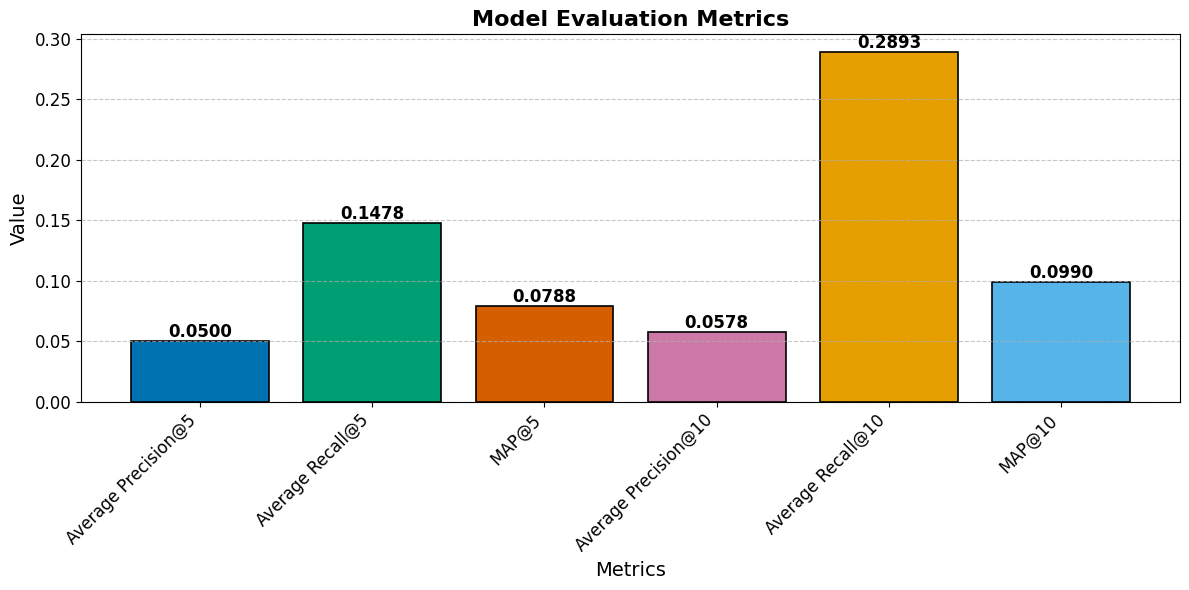

In [12]:
# Sample data (replace with actual values)
metrics = {
    'Metric': ['Average Precision@5', 'Average Recall@5', 'MAP@5', 'Average Precision@10', 'Average Recall@10', 'MAP@10'],
    'Value': [avg_precision_5, avg_recall_5, avg_map_5, avg_precision_10, avg_recall_10, avg_map_10]
}
metrics_df = pd.DataFrame(metrics)

# Plotting
plt.figure(figsize=(12, 6))

# Colorblind-friendly colors
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#E69F00', '#56B4E9']

# Create the bar plot with colorblind-friendly colors and increased font sizes
bars = plt.bar(metrics_df['Metric'], metrics_df['Value'], color=colors, edgecolor='black', linewidth=1.2)

# Annotate the bars with values
for bar, value in zip(bars, metrics_df['Value']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{value:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Labels and Title
plt.xlabel("Metrics", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.title("Model Evaluation Metrics", fontsize=16, fontweight='bold')

# Adjust x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Y-axis ticks
plt.yticks(fontsize=12)

# Grid and layout
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


### 7. Generate recommendations for all users


In [13]:
user_recommendations = model.recommendForAllUsers(10)

# Show user recommendations
user_recommendations.show()

+----------+--------------------+
|ReviewerId|     recommendations|
+----------+--------------------+
|         1|[{69, 0.2802256},...|
|         3|[{69, 0.35886362}...|
|         5|[{31, 0.33214203}...|
|         6|[{69, 0.31935278}...|
|         9|[{31, 0.34756088}...|
|        12|[{99, 0.0}, {98, ...|
|        13|[{5, 0.059572004}...|
|        15|[{33, 0.11379229}...|
|        19|[{36, 0.24777214}...|
|        20|[{31, 0.3279075},...|
|        22|[{99, 0.0}, {98, ...|
|        26|[{25, 0.060202006...|
|        27|[{31, 0.32532433}...|
|        28|[{36, 0.24777214}...|
|        31|[{69, 0.11039363}...|
|        34|[{69, 0.28000894}...|
|        35|[{31, 0.36334622}...|
|        41|[{69, 0.3224216},...|
|        43|[{99, 0.0}, {98, ...|
|        44|[{69, 0.3224216},...|
+----------+--------------------+
only showing top 20 rows



Pada bagian akhir ini, ditampilkan hasil rekomendasi untuk setiap pengguna berdasarkan model ALS yang telah dilatih. Fungsi `recommendForAllUsers(10)` memberikan 10 rekomendasi tempat wisata teratas untuk setiap pengguna, di mana angka 10 menunjukkan jumlah rekomendasi yang ingin diberikan kepada setiap pengguna. Hasil dari `recommendForAllUsers(10)` disimpan dalam variabel `user_recommendations`, dan fungsi `show()` digunakan untuk menampilkan hasil rekomendasi ini. Hasil yang ditampilkan akan menunjukkan kolom `ReviewerId` (ID pengguna) dan `recommendations` (daftar tempat yang direkomendasikan untuk pengguna tersebut). Setiap rekomendasi dalam kolom tersebut berisi ID tempat yang diprediksi akan disukai oleh pengguna.

In [18]:
# Mengambil rekomendasi untuk semua pengguna (Top-10 untuk setiap pengguna)
user_recommendations = model.recommendForAllUsers(10)

# Ambil hanya rekomendasi untuk ReviewerId = 1554
user_1554_recommendations = user_recommendations.filter(user_recommendations.ReviewerId == 1554)

# Ambil hanya 5 rekomendasi pertama untuk user 1554
top_5_user_1554 = user_1554_recommendations.select("ReviewerId", "recommendations").first().recommendations[:5]

# Mengambil hanya PlaceID dari rekomendasi
top_5_place_ids = [row["PlaceID"] for row in top_5_user_1554]

# Mengonversi ID tempat wisata ke dalam DataFrame Spark
place_ids_df = spark.createDataFrame([(place_id,) for place_id in top_5_place_ids], ["PlaceID"])

# Gabungkan dengan DataFrame asli untuk mendapatkan nama tempat wisata
recommended_places = place_ids_df.join(spark_df.select("PlaceID", "Nama_tempat_wisata"), on="PlaceID", how="inner")

# Menampilkan hasil
recommended_places.show(truncate=False)


+-------+---------------------------------------------+
|PlaceID|Nama_tempat_wisata                           |
+-------+---------------------------------------------+
|31     |Desa Wisata Sigapiton                        |
|31     |Desa Wisata Sigapiton                        |
|31     |Desa Wisata Sigapiton                        |
|38     |Istana Kaldera Unesco Geopark Danau Toba     |
|38     |Istana Kaldera Unesco Geopark Danau Toba     |
|38     |Istana Kaldera Unesco Geopark Danau Toba     |
|38     |Istana Kaldera Unesco Geopark Danau Toba     |
|38     |Istana Kaldera Unesco Geopark Danau Toba     |
|38     |Istana Kaldera Unesco Geopark Danau Toba     |
|38     |Istana Kaldera Unesco Geopark Danau Toba     |
|38     |Istana Kaldera Unesco Geopark Danau Toba     |
|38     |Istana Kaldera Unesco Geopark Danau Toba     |
|38     |Istana Kaldera Unesco Geopark Danau Toba     |
|38     |Istana Kaldera Unesco Geopark Danau Toba     |
|38     |Istana Kaldera Unesco Geopark Danau Tob

In [21]:
# Mapping PlaceID to Place Name (from the original dataset)
place_name_map = data[['PlaceID', 'Nama_tempat_wisata']].drop_duplicates().set_index('PlaceID').to_dict()['Nama_tempat_wisata']

# Ambil rekomendasi untuk semua pengguna (sudah dilakukan sebelumnya)
user_recommendations = model.recommendForAllUsers(10)

# Filter rekomendasi untuk user dengan ID 1554
user_1554_recommendations = user_recommendations.filter(user_recommendations.ReviewerId == 1554)

# Ambil 5 rekomendasi teratas untuk user 1554
top_5_recommendations = user_1554_recommendations.select("ReviewerId", "recommendations").first()

# Reverse the normalization process:
# You need the `mean_rating` and `std_rating` values to reverse the normalization.
mean_rating = rating_stats["mean"]
std_rating = rating_stats["std"]

# Tampilkan 5 rekomendasi teratas dengan nama tempat dan rating yang sudah dinormalisasi
if top_5_recommendations:
    recommended_places = top_5_recommendations['recommendations']
    # Ambil hanya 5 tempat teratas
    top_5_places = recommended_places[:5]
    print(f"Top 5 recommendations for user 1554:")
    for idx, place in enumerate(top_5_places, 1):
        place_name = place_name_map.get(place['PlaceID'], 'Unknown Place')  # Fetch the place name

        # Reverse the normalization of the predicted rating
        original_rating = (place['rating'] * std_rating) + mean_rating

        # Print the place name, PlaceID, and original predicted rating
        print(f"{idx}. {place_name} (PlaceID: {place['PlaceID']}), Predicted Rating: {original_rating:.2f}")
else:
    print("No recommendations found for user 1554.")


Top 5 recommendations for user 1554:
1. Desa Wisata Sigapiton (PlaceID: 31), Predicted Rating: 4.78
2. Istana Kaldera Unesco Geopark Danau Toba (PlaceID: 38), Predicted Rating: 4.76
3. Pelabuhan wisata danau toba (PlaceID: 69), Predicted Rating: 4.75
4. Objek Wisata Budaya Batu Kursi Raja Siallagan (PlaceID: 50), Predicted Rating: 4.73
5. Air Terjun Siboruon (PlaceID: 6), Predicted Rating: 4.73
